In [86]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
from matplotlib import rcParams
from tqdm import tqdm
from pyfcd.fcd import calculate_carriers, fcd
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from natsort import natsorted
import ast

FRAME_PER_SECOND = 60
plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
# rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR

# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 26
rcParams['xtick.labelsize'] = 26
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'

In [87]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False):
    im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, blockSize=17, C=3)
    if PRUEBA:
        cv.imwrite('binary.jpg', im_binary)
    return im_binary

def blur(frame):
    im_blur = cv.GaussianBlur(frame, (17,17), 3)
    return im_blur

def obtener_deformacion(vs, carriers, start = 0, finish = None, SHOW=False, mask=None):
    frame_count = int(vs.get(7))
    width  = int(vs.get(3)) - (int(vs.get(3)) - mask[3]) - (mask[2])  # float `width`
    height = int(vs.get(4)) - (int(vs.get(4)) - mask[1]) - (mask[0])  # float `height`
    i=0
    if finish is None:
        finish = frame_count
        
    maps = np.zeros((finish - start + 1,height,width))
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            if mask:
                frame_processed = blur(binarize(gris(frame[mask[0]:mask[1],mask[2]:mask[3]])))

            if i>=start and i<=finish:
                height_map = fcd(frame_processed, carriers)
                i_frame = i - start
                maps[i_frame] = height_map
            if SHOW:
                cv.imshow('frame', frame_processed)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
            i+=1
        else:
            break
        
    cv.destroyAllWindows()
    return maps,(height,width)

def load_head_trayectories(tag,volt,frec):
    df = pd.read_csv(f'{tag}/{volt}-{frec}.csv')
    t,x,y,frame = df['t']*FRAME_PER_SECOND, df['x'], df['y'], df['frame']
    return x,y,t,frame

w2_func = lambda l,a,b,c: (a*(2*np.pi/l) + b*(2*np.pi/l)**3)*np.tanh((2*np.pi/l)*c)
dw2_dl_func = lambda l,a,b,c: (a*(2*np.pi/l) + b*(2*np.pi/l)**3)*(1/np.cosh(c*(2*np.pi/l))**2)*(c/l**2) \
                                    + (a*(2*np.pi/l)**2 + b*(2*np.pi/l)**4)*np.tanh(c*(2*np.pi/l))

def get_freq(l, dl):
    gravedad = 9810 #[mm/s²]
    profundidad = 53 #[mm]
    gamma = 50e3 # [mN/mm]
    w2 = w2_func(l,gravedad,gamma,profundidad)
    err_w2 = dw2_dl_func(l, gravedad, gamma, profundidad)*dl
    err_omega = .5*w2**(-1/2)*err_w2
    return np.sqrt(w2)/(2*np.pi),err_omega/(2*np.pi)

def obtener_imagenes_crudas(vs, start = 0, finish = None, SHOW=False, mask = None):
    frame_count = int(vs.get(7))
    width  = int(vs.get(3)) - (int(vs.get(3)) - mask[3]) - mask[2]  # float `width`
    height = int(vs.get(4)) - (int(vs.get(4)) - mask[1]) - mask[0] # float `height`
    i=0
    if finish is None:
        finish = frame_count
        
    maps = np.zeros((finish - start + 1,height,width))
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            if i>=start and i<=finish:
                i_frame = i - start
                maps[i_frame] = gris(frame[mask[0]:mask[1],mask[2]:mask[3],:])
            if SHOW:
                cv.imshow('frame', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
            i+=1
        else:
            break
        
    cv.destroyAllWindows()
    return maps


In [88]:
freq=10
volt=2
FILENAME=f'P1-{volt}V-{freq}Hz-60mm'

calibrations = pd.read_csv('calibrations_fcd_dsk_60mm.csv')
PX_PER_MM = calibrations[calibrations['freq [Hz]']==freq][calibrations['volt [Vpp]']==volt]['calibration [px mm-1]'].iloc[0]

amplitude_params = pd.read_csv('amplitude_parameters.csv')
amplitude_params = amplitude_params[amplitude_params['freq [Hz]']==freq][amplitude_params['volt [Vpp]']==volt]
y0 = amplitude_params.y_start.iloc[0]
m = amplitude_params.angle.iloc[0]
i_frame = amplitude_params.i_frame.iloc[0].astype(int)

vs = cv.VideoCapture(f'videos/FCD/negro/60mm/{FILENAME}.mp4')
mask = [110,600,100,1200] # ymin, ymax, xmin, xmax
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret:
        frame = gris(frame[mask[0]:mask[1],mask[2]:mask[3],:])
        if i==0:
            ref_frame = frame
        i+=1
        cv.imshow('frame', frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

/tmp/ipykernel_332058/1895615922.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PX_PER_MM = calibrations[calibrations['freq [Hz]']==freq][calibrations['volt [Vpp]']==volt]['calibration [px mm-1]'].iloc[0]
/tmp/ipykernel_332058/1895615922.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  amplitude_params = amplitude_params[amplitude_params['freq [Hz]']==freq][amplitude_params['volt [Vpp]']==volt]


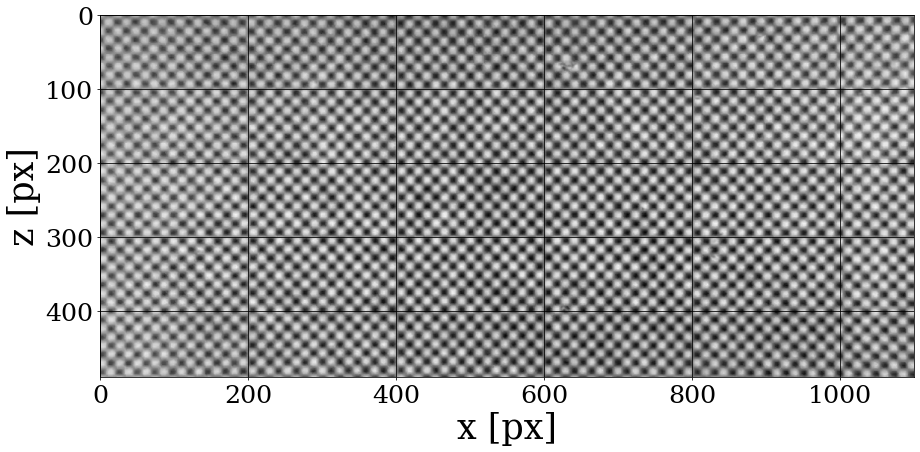

In [89]:
%matplotlib inline
plt.imshow(ref_frame, cmap='gray')
plt.xlabel('x [px]')
plt.ylabel('z [px]')
plt.show()

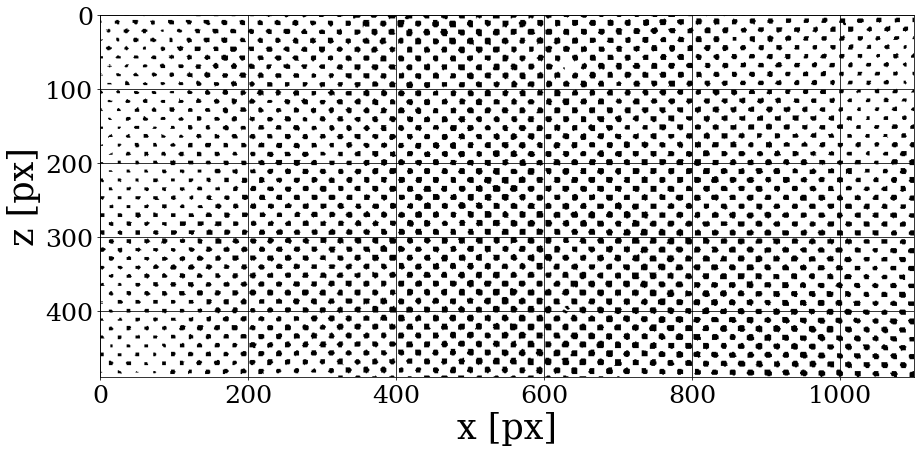

In [90]:
%matplotlib inline
_, im = cv.threshold(ref_frame,thresh=127, maxval=255, type=cv.THRESH_BINARY)
plt.imshow(im, cmap='gray')
plt.xlabel('x [px]')
plt.ylabel('z [px]')
plt.show()

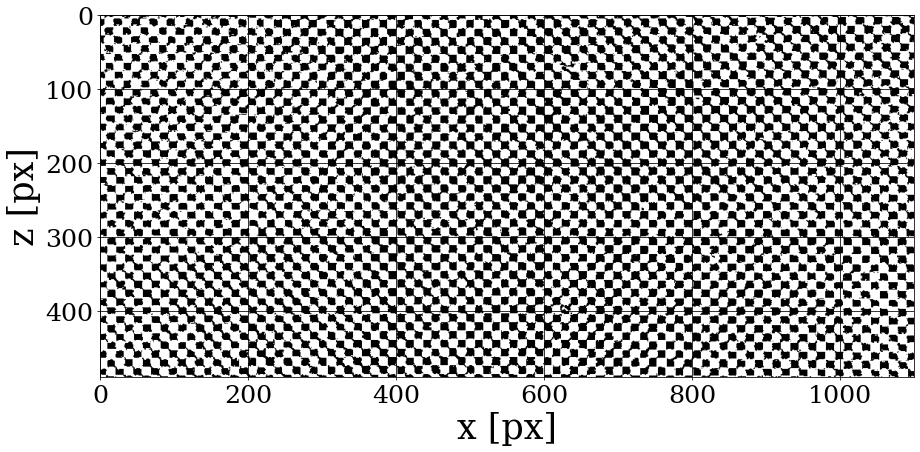

In [91]:
%matplotlib inline
im_binary = cv.adaptiveThreshold(ref_frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, blockSize=17, C=3)
plt.imshow(im_binary, cmap='gray')
plt.xlabel('x [px]')
plt.ylabel('z [px]')
plt.show()

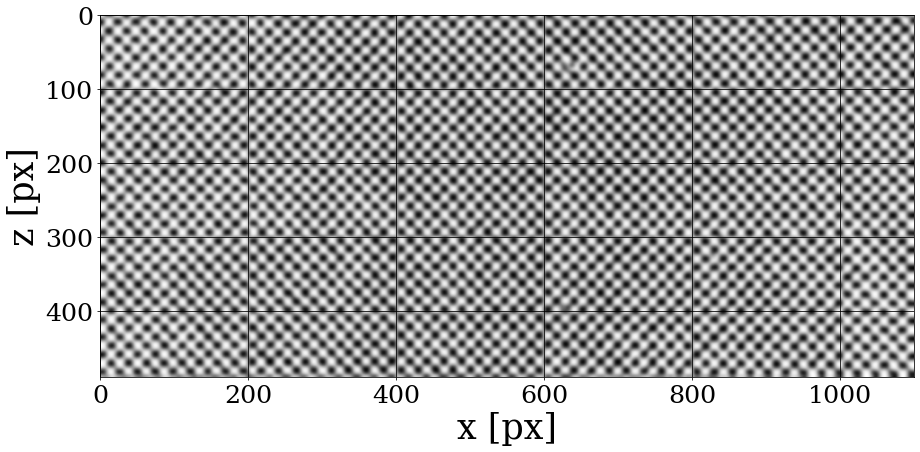

In [92]:
im_blurred = cv.GaussianBlur(im_binary, (17,17), 3)
plt.xlabel('x [px]')
plt.ylabel('z [px]')
plt.imshow(im_blurred, cmap='gray')

In [93]:
try:
    data = np.load(f'schlieren_maps/{FILENAME}/{FILENAME}.npz', allow_pickle=True)
    maps,x,y = data['maps'],data['x'],data['y']
    x_len = maps[0].shape[1]
    y_len = maps[0].shape[0]
    max_height = max([abs(maps[i]).max() for i in np.arange(len(maps))])
    norm = plt.Normalize(-max_height, max_height)
    cmap = plt.colormaps.get_cmap('seismic')
    colorscale = plt.cm.ScalarMappable(norm, cmap)
except FileNotFoundError:
    #Obtengo las mediciones de trayectoria de x e y para el video seleccionado
    x,y,t,frame = load_head_trayectories('DSK-60mm/revisited', f'{volt}V', f'{freq}Hz')

    df_xy = pd.DataFrame().assign(x=x).assign(y=y)

    #Selecciono el frame inicial y final en el que se empieza a medir la trayectoria de la cabeza
    start = frame.iloc[0]
    finish = frame.iloc[-1]

    vs = cv.VideoCapture(f'videos/FCD/negro/60mm/{FILENAME}.mp4')

    #Calculo los vectores de número de onda para mi patrón de checkerboard
    carriers = calculate_carriers(im_blurred, MM_PER_PX=(PX_PER_MM)**-1)

    #Obtengo el mapa de deformaciones a partir de que se empieza a ver la cabeza y hasta que se va del frame
    #Por comodidad también devuelvo la altura y el ancho de los campos de deformación en px
    maps,(height,width) = obtener_deformacion(vs,carriers,start = start,finish = finish, SHOW=True, mask = mask)
    
    # Obtengo las dimensiones de las imágenes
    x_len = width
    y_len = height

    #Quito 1% de cada lado en "y" y 1% de cada lado en "x" para evitar los artefactos por los bordes del checkerboard.
    maps = maps[:,int(.01*y_len):int(.99*y_len),int(.1*x_len):int(.9*x_len)]

    # #Ajusto los bordes de mis vectores de posición de la cabeza x e y
    df_xy = df_xy[df_xy.x<int(.9*x_len)][df_xy.x>int(.1*x_len)]
    df_xy.x = (df_xy.x - int(.1*x_len))
    maps = maps[df_xy.index[0]:df_xy.index[-1] + 1,:,:]
    
    x,y = df_xy.x.to_numpy(),df_xy.y.to_numpy()
    
    #Actualizo los límites temporales de los campos de deformación en base al máximo valor que toma x
    x_len = maps[0].shape[1]
    y_len = maps[0].shape[0]
    np.savez(f'schlieren_maps/{FILENAME}/{FILENAME}.npz', maps= maps, x= x, y= y)

In [50]:
doWeWantToSaveTheBareImages = False

if doWeWantToSaveTheBareImages:
    vs = cv.VideoCapture(f'videos/FCD/negro/60mm/{FILENAME}.mp4')

    #Obtengo las mediciones de trayectoria de x e y para el video seleccionado
    _,_,_,frame = load_head_trayectories('DSK-60mm/revisited', f'{volt}V', f'{freq}Hz')

    #Selecciono el frame inicial y final en el que se empieza a medir la trayectoria de la cabeza
    start = frame.iloc[0]
    finish = frame.iloc[-1]

    crude_maps = obtener_imagenes_crudas(vs,start,finish,mask=mask)

    for i_frame in tqdm(np.arange(len(maps))):
        plt.figure()
        plt.imshow(crude_maps[i_frame], aspect='equal')
        plt.ylabel('z [px]')
        plt.xlabel('x [px]')
        plt.grid()
        plt.savefig(f'./schlieren_maps/{FILENAME}/images_bw/{i_frame:03}.tiff')
        plt.close()

100%|██████████| 87/87 [00:28<00:00,  3.03it/s]


240.0 0.0


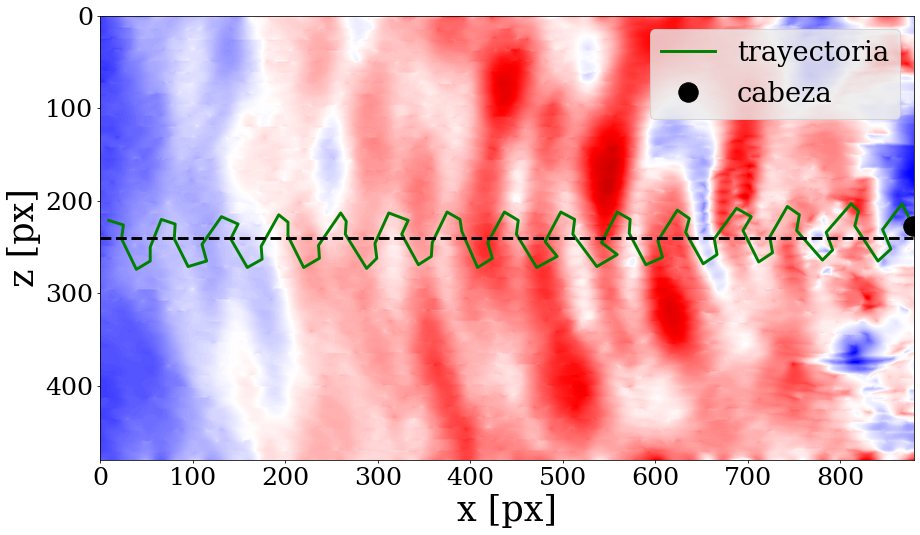

In [94]:
%matplotlib inline
# i_frame = 35
x_head, y_head = x[i_frame], y[i_frame]
xs = np.arange(0,x_head).astype(int)[::-1]

# y0 = 220
# m = -np.tan(np.pi - np.pi*(1020/1000))
print(y0,m)
line_amp = (m*(np.arange(0,x_len) - x_head) + y0).astype(int)

plt.figure()

plt.plot(x,y, color='g', lw=3, label='trayectoria')
plt.plot(x_head,y_head,'o',ms=20,color='k', label='cabeza')
plt.imshow(maps[i_frame], aspect='equal', cmap=cmap, norm = norm)
plt.plot(np.arange(0,x_len), line_amp, ls='--', color='k', lw=3)

plt.ylabel('z [px]')
plt.xlabel('x [px]')
plt.grid()
plt.legend()
plt.show()

In [62]:
[print(i,len(item)) if len(item)>100 else None for i,item in enumerate(cs.allsegs[15])]
[]

0 272
12 159


[]

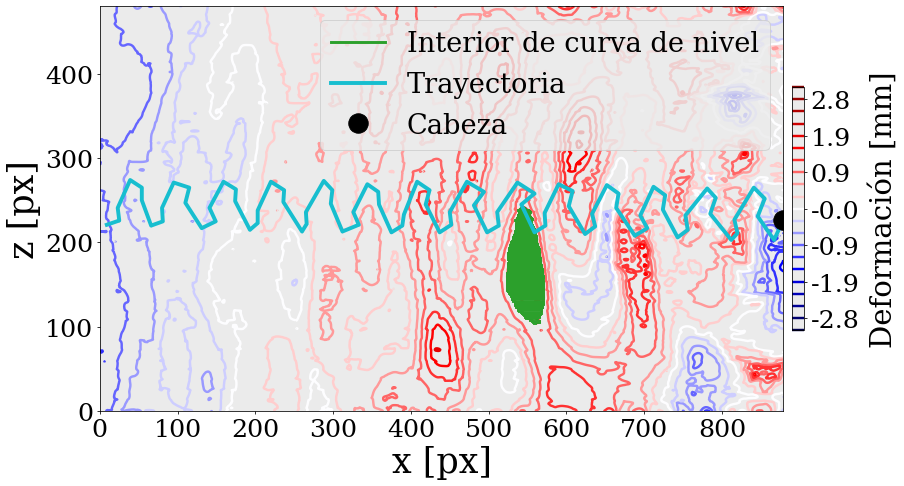

In [107]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15*0.5011363636363636))
X,Y = np.meshgrid(np.arange(x_len),np.arange(y_len))
# plt.imshow(maps[i_frame], aspect='equal', cmap=cmap, norm = norm)
levels = np.arange(-max_height,1.1*max_height,.1*max_height)
cs = ax.contour(X,Y,maps[i_frame], levels,linewidths=2.5, cmap=cmap, norm = norm)

# xc, yc = cs.allsegs[10][48].T # contour for 1-15
# xc, yc = cs.allsegs[10][95].T # contour for 2-15
# xc,yc = cs.allsegs[9][15].T # countour for 1-10
xc,yc = cs.allsegs[14][12].T # countour for 2-10
# xc,yc = cs.allsegs[15][12].T # countour for 2-10
# xc,yc = cs.allsegs[8][10].T # countour for 3-10
# xc,yc = cs.allsegs[16][3].T # contour for 1-5
# xc,yc = cs.allsegs[11][4].T # countour for 2-5
# xc, yc = cs.allsegs[9][13].T # contour for 3-5
# xc, yc = cs.allsegs[10][45].T # contour for 4-5
y_edge = np.array([int(np.round(i)) for i in yc])
x_edge = np.array([int(np.round(i)) for i in xc])
Xc,Yc = np.meshgrid(np.arange(x_len),np.arange(y_len))
for xe,ye in zip(x_edge,y_edge):
    Xc[ye,xe] = -1
    Yc[ye,xe] = -1
xs_inside = np.zeros(len(set(y_edge)), dtype=object)
for i,ye in enumerate(set(y_edge)):
    borders = np.where(Xc[ye,:]==-1)[0]
    if len(borders)>1:
        xs_inside[i] = X[ye,borders[0]: borders[1] + 1]
    else:
        xs_inside[i] = []

cbar = fig.colorbar(cs, pad=1e-2, shrink=0.6)
ticks = cbar.ax.get_yticks()
cbar.set_ticks(ticks)         # Ensure the ticks match
cbar.ax.set_yticklabels([f"{tick:.1f}" for tick in ticks])
cbar.ax.set_ylabel('Deformación [mm]',labelpad=10, fontsize=30)
ax.plot(xc,yc, color='k', ls ='--')

for i,ye in enumerate(set(y_edge)):
    if len(xs_inside[i])>0:
        if i==0:
            ax.axhline(y = ye, xmin = xs_inside[i][0]/x_len, xmax= xs_inside[i][-1]/x_len, color='C2', lw=3, label = 'Interior de curva de nivel')
        else:
            ax.axhline(y = ye, xmin = xs_inside[i][0]/x_len, xmax= xs_inside[i][-1]/x_len, color='C2', lw=3)

plt.plot(x,y, '.-', color='C9', ms=1, label='Trayectoria',lw=4)
plt.plot(x_head,y_head,'o',ms=20,color='k', label='Cabeza')
plt.ylabel('z [px]')
plt.xlabel('x [px]')
plt.legend(loc='best')

plt.grid()
plt.show()

In [120]:
doWeWantToSaveTheDeformationMaps = False

if doWeWantToSaveTheDeformationMaps:
    for i_frame in tqdm(np.arange(len(maps)-1)):
        x_head, y_head = x[i_frame], y[i_frame]
        plt.figure()
        plt.imshow(maps[i_frame], aspect='equal', cmap=cmap, norm = norm)
        plt.plot(x,y, color='g', lw=3, label='Trayectoria')
        plt.plot(x_head,y_head,'o',ms=10,color='k', label='Cabeza')

        cbar_term = plt.colorbar(pad=5e-2, shrink=0.43)
        cbar_term.ax.ticklabel_format(axis='y',style='sci',scilimits=(0,2))
        cbar_term.ax.set_ylabel('Deformación [mm]',labelpad=10, fontsize=30)

        plt.ylabel('z [px]')
        plt.xlabel('x [px]')
        plt.grid()
        plt.legend()
        plt.savefig(f'./schlieren_maps/{FILENAME}/images/{i_frame:03}.tiff')
        plt.close()

100%|██████████| 86/86 [00:24<00:00,  3.50it/s]


In [28]:
try:
    map_fft = np.load(f'schlieren_maps/{FILENAME}/{FILENAME}_fft.npz', allow_pickle=True)['map_fft']
    s = len(maps)
    fr = np.linspace(0,30,s//2 + 1)
except FileNotFoundError:
    s = len(maps)
    map_fft = np.zeros((s//2 + 1,y_len,x_len)).astype(np.complex128)
    fr = np.linspace(0,30,s//2 + 1)

    for i in np.arange(y_len):
        for j in np.arange(x_len):
            map_fft[:,i,j] = np.fft.rfft(maps[:,i,j])
    
    np.savez(f'schlieren_maps/{FILENAME}/{FILENAME}_fft.npz', map_fft = map_fft)

[]

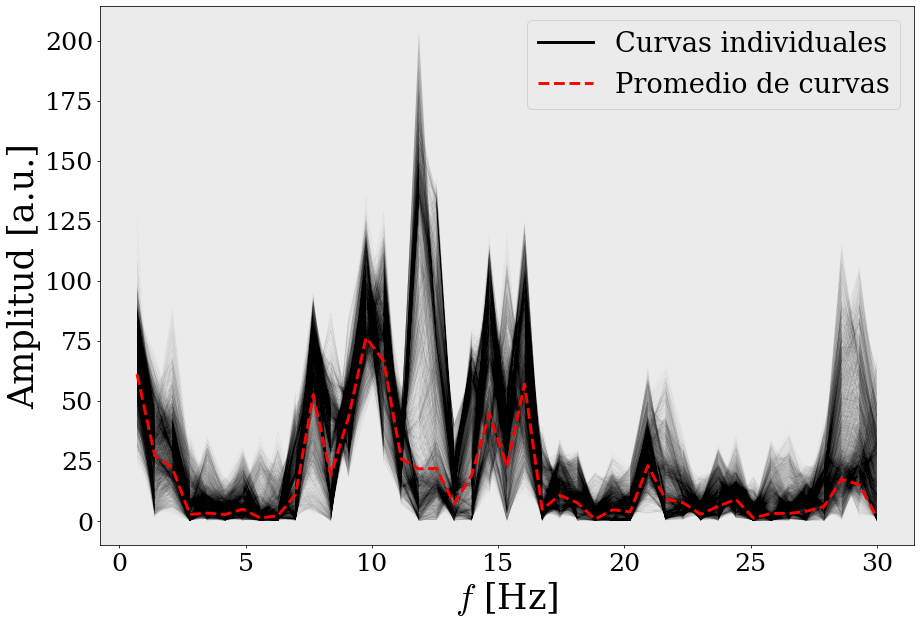

In [47]:
%matplotlib inline
avg_map_fft = np.zeros((s//2 + 1), dtype=object)
envolvente_fft = np.zeros(((s//2 + 1)), dtype=object)

n_points=0
for i,_ in enumerate(set(y_edge)):
    for j,_ in enumerate(xs_inside[i]):
        n_points+=1

fig,ax = plt.subplots()

for i,ye in enumerate(set(y_edge)):
    for j,xj in enumerate(xs_inside[i]):
        avg_map_fft+=map_fft[:,ye,xj]
        envolvente_fft = np.array([max(envolvente_fft[n],np.abs(map_fft[n,ye,xj])**2) for n in np.arange((s//2 + 1))])
        if i==0 and j==0:
            ax.plot(fr[1:], np.abs(map_fft[1:,ye,xj])**2, 'k', alpha=0.1, lw=.1, label='Curvas individuales')
        else:
            ax.plot(fr[1:], np.abs(map_fft[1:,ye,xj])**2, 'k', alpha=0.1, lw=.1)

avg_map_fft = (np.abs(avg_map_fft/n_points)**2)
ax.plot(fr[1:], avg_map_fft[1:], color='r', ls='--', lw=3, label='Promedio de curvas')

handles, labels = ax.get_legend_handles_labels()

for handle, label in zip(handles, labels):
    if label == 'Curvas individuales':
        handle.set_alpha(1)
        handle.set_linewidth(3)
        
        # Update the legend
        ax.legend(handles, labels)
        
        handle.set_alpha(.1)
        handle.set_linewidth(.1)

ax.set_ylabel('Amplitud [a.u.]')
ax.set_xlabel('$f$ [Hz]')
ax.grid()
[]

[ 2.09302326  4.18604651  7.6744186   9.76744186 11.86046512 14.65116279
 20.23255814 23.02325581 24.41860465 26.51162791 29.30232558]


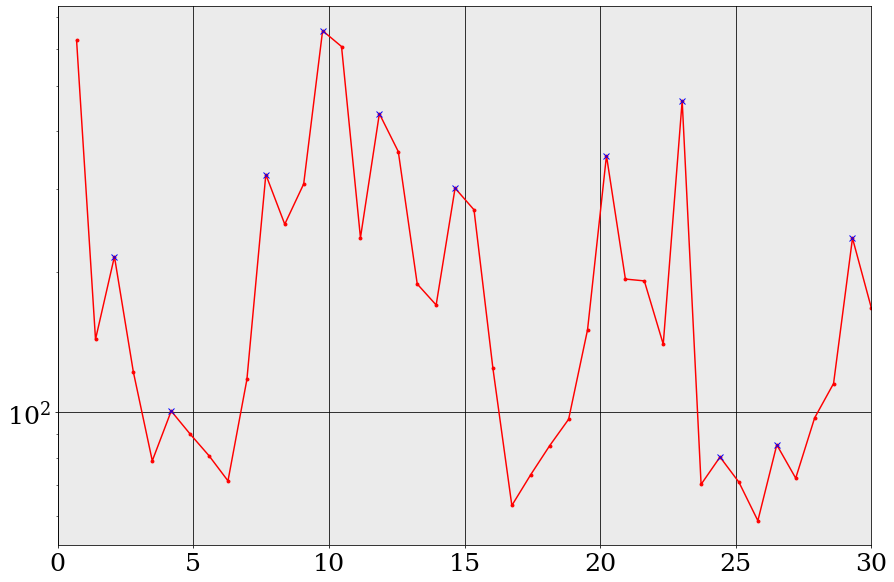

In [17]:
%matplotlib widget
xp,dict_peaks = find_peaks(envolvente_fft)
print(fr[xp])
plt.figure()
plt.plot(fr[1:],envolvente_fft[1:],'.-', color='r')
plt.plot(fr[xp],envolvente_fft[xp],'x', color='b')
plt.xlim([0,30])
plt.semilogy()
plt.show()

In [21]:
%matplotlib inline
plt.close()

[ 2.79069767  4.18604651  7.6744186  10.46511628 12.55813953 14.65116279
 18.13953488 20.23255814 23.02325581 24.41860465 26.51162791 28.60465116]


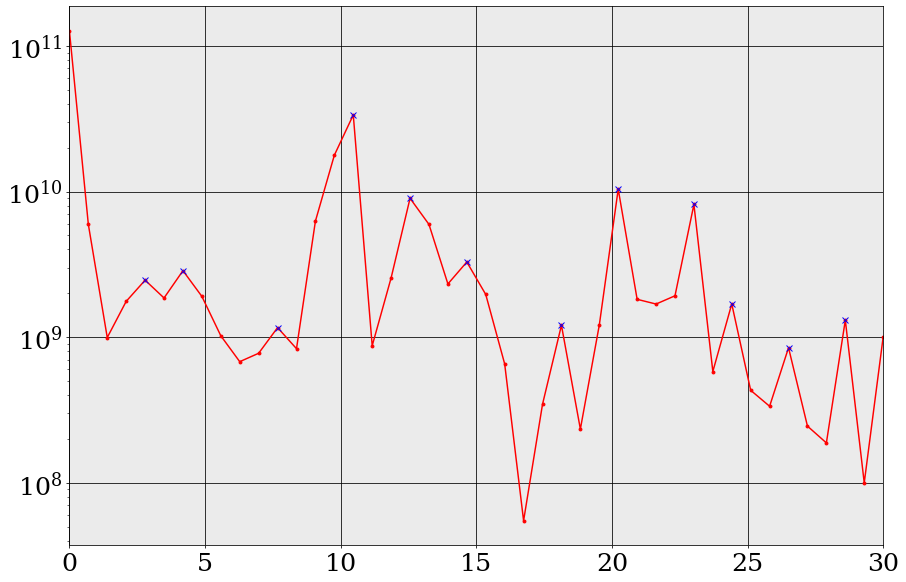

In [31]:
%matplotlib widget
xp,dict_peaks = find_peaks(avg_map_fft)
print(fr[xp])
plt.figure()
plt.plot(fr,avg_map_fft,'.-', color='r')
plt.plot(fr[xp],avg_map_fft[xp],'x', color='b')
plt.xlim([0,30])
plt.semilogy()
plt.show()

In [70]:
%matplotlib inline
plt.figure()
plt.close()

In [48]:
freq_csv = pd.read_csv('exploratory_wk.csv')

print("Current experiment paramenters are:",freq,"Hz and",volt,"Vpp")
freqs_experiment = freq_csv[freq_csv['volt [Vpp]']==volt][freq_csv['freq [Hz]']==freq]
f1 = freqs_experiment['f1 [Hz]']
f2 = freqs_experiment['f2 [Hz]']

Current experiment paramenters are: 10 Hz and 2 Vpp


/tmp/ipykernel_332058/134416884.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  freqs_experiment = freq_csv[freq_csv['volt [Vpp]']==volt][freq_csv['freq [Hz]']==freq]


La longitud de onda promedio es:  8.767721554363243  \pm  0.17018413257880305 mm
La longitud de onda promedio es:  68.33333333333334  \pm  1.3263707095903685 px
Cuya longitud de onda corresponde a una frecuencia de: (25.380820763294313, 1.547703808435172)


[]

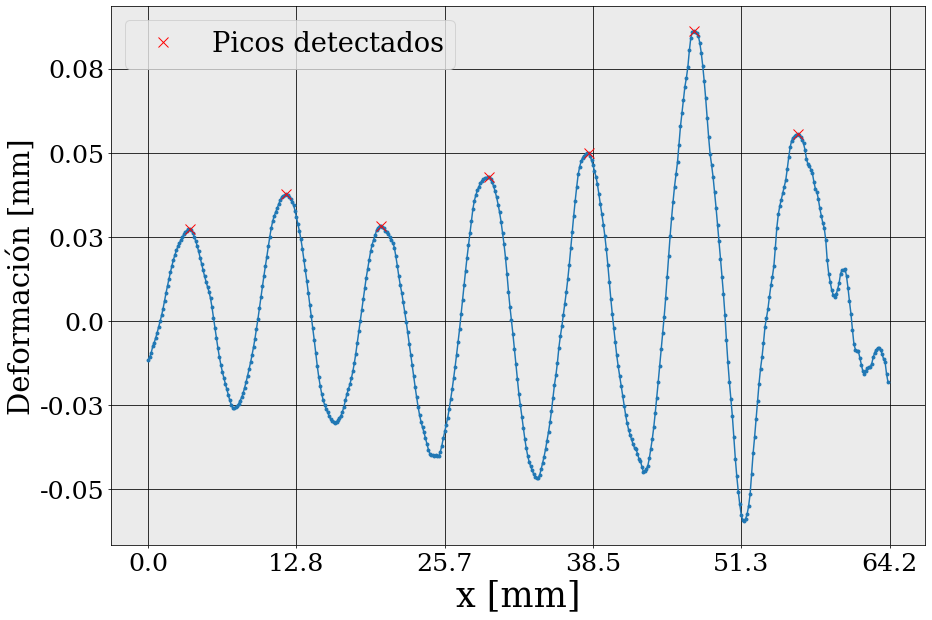

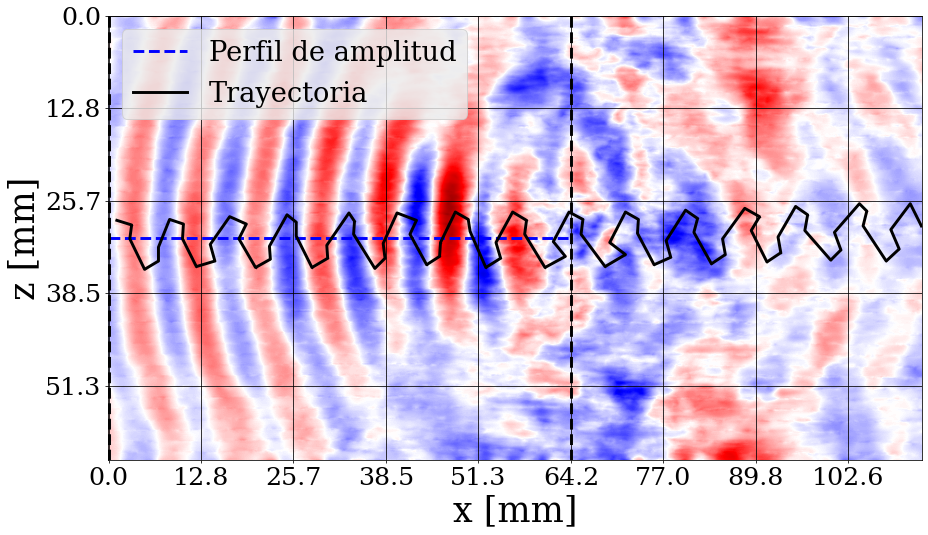

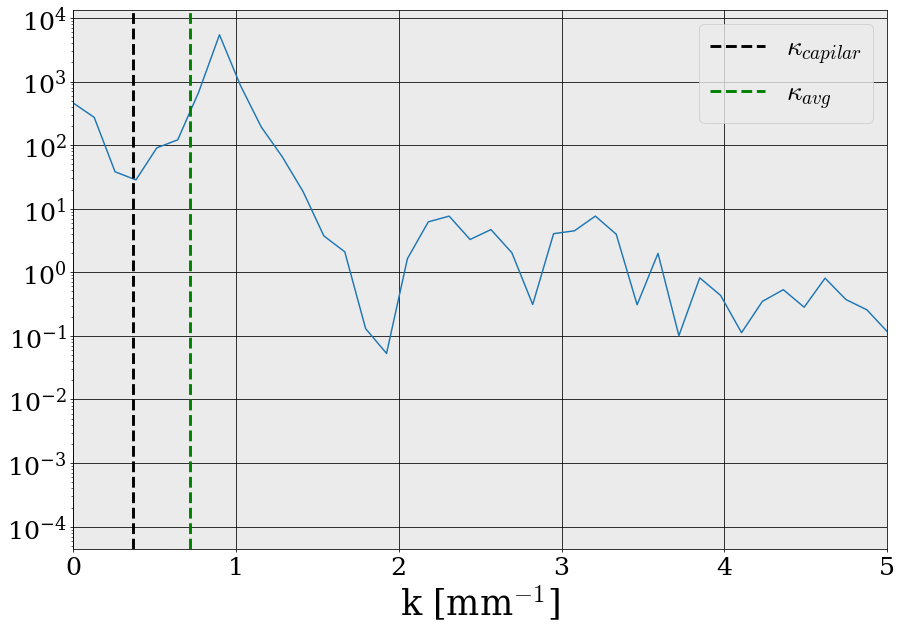

In [150]:
%matplotlib inline

i_frame=30

s = len(maps) - 1
filter_map = np.zeros((s,y_len,x_len))

fr = np.linspace(0,30,s//2 + 1)
filtro = np.ones_like(fr)
i_filter = 9
filtro[np.where(np.logical_or(fr<f1.iloc[i_filter],fr>f2.iloc[i_filter]))] = 0
# filtro[np.where(np.logical_or(fr<26.8,fr>30))] = 0

for i in np.arange(y_len):
    for j in np.arange(x_len):
        masked_fft = np.fft.rfft(maps[:,i,j])*filtro
        filter_map[:,i,j] = np.fft.irfft((masked_fft))

x_min = 0
x_max = 500
xs = np.arange(x_min,x_max)

# y0 = 360
line_amp = (m*(xs - x_head) + y0).astype(int)

filter_frame = savgol_filter(filter_map[i_frame,line_amp,xs], polyorder=5, window_length=6)

pk_l = find_peaks(filter_frame, width=[10,100], distance=15)[0]

lambs = np.diff(xs[pk_l]/PX_PER_MM)
l_mean = np.mean(lambs)
l_std = np.std(np.diff(xs[pk_l]/PX_PER_MM))/np.sqrt(len(lambs))

max_height = max([abs(filter_map[i]).max() for i in np.arange(len(filter_map))])
norm = plt.Normalize(-max_height, max_height)
cmap = plt.colormaps.get_cmap('seismic')
colorscale = plt.cm.ScalarMappable(norm, cmap)


fig1,ax1 = plt.subplots()
ax1.plot(xs, filter_frame,'.-')
ax1.set_xlabel('x [mm]')
ax1.set_ylabel('Deformación [mm]', fontsize=30)
ax1.plot(xs[pk_l], filter_frame[pk_l], 'x', ms=10, color='r', label='Picos detectados')
plt.xticks(ticks= plt.xticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.xticks()[0][1:-1]])
plt.yticks(ticks= plt.yticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),2)) for i in plt.yticks()[0][1:-1]])
ax1.legend()

fig2,ax2 = plt.subplots()
im = ax2.imshow(filter_map[i_frame], aspect='equal', cmap=cmap, norm = norm)
ax2.plot(xs, line_amp,'--', label='Perfil de amplitud', lw=3, color='b')
ax2.plot(x,y, '.-', color='k', ms=1, label='Trayectoria',lw=3)
ax2.axvline(x_min, ls='--', color='k',lw=3)
ax2.axvline(x_max, ls='--', color='k',lw=3)

ax2.set_ylabel('z [mm]')
ax2.set_xlabel('x [mm]')
ax2.legend(loc='upper left')
plt.xticks(ticks= plt.xticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.xticks()[0][1:-1]])
plt.yticks(ticks= plt.yticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.yticks()[0][1:-1]])

# ksp,_ = find_peaks(ks, height=.2)
# wsp = peak_widths(ks, ksp, rel_height=0.5)
# l_k = (2*np.pi/ks_w[ksp])
# l_width = (2*np.pi/wsp[0])

# También podemos estudiar la longitud de onda obtenida en el k-espacio de la amplitud
# Generalmente no da bien, como podemos observar...
ks = np.abs(np.fft.rfft(filter_frame))**2
ks_w = np.linspace(0,(xs[-1]//2), len(xs)//2 + 1)*(PX_PER_MM)

fig,ax = plt.subplots()
ax.plot(ks_w,ks)
ax.axvline(x=2*np.pi/17, color='k', ls='--', lw=3, label='$\\kappa_{capilar}$')
ax.axvline(x=(2*np.pi/l_mean), color='g', ls='--', lw=3, label='$\\kappa_{avg}$')
ax.set_xlabel('k [mm$^{-1}$]')
ax.set_xlim([0,100])
ax.legend()
ax.semilogy()

print("La longitud de onda promedio es: ",l_mean," \pm ",l_std,"mm")
print("La longitud de onda promedio es: ",l_mean*PX_PER_MM," \pm ",l_std*PX_PER_MM,"px")
print("Cuya longitud de onda corresponde a una frecuencia de:", get_freq(l_mean,l_std))
[]

In [124]:
import os
for i_filter in np.arange(len(f1)):
    print(i_filter)
    if not os.path.isdir(f'./schlieren_maps/filter_{i_filter}_{FILENAME}/'):
        os.mkdir(f'./schlieren_maps/filter_{i_filter}_{FILENAME}')
        os.mkdir(f'./schlieren_maps/filter_{i_filter}_{FILENAME}/images')
    if len(os.listdir(f'./schlieren_maps/filter_{i_filter}_{FILENAME}/images'))==0:
        s = len(maps) - 1
        filter_map = np.zeros((s,y_len,x_len))

        fr = np.linspace(0,30,s//2 + 1)
        filtro = np.ones_like(fr)
        filtro[np.where(np.logical_or(fr<f1.iloc[i_filter],fr>f2.iloc[i_filter]))] = 0

        for i in np.arange(y_len):
            for j in np.arange(x_len):
                masked_fft = np.fft.rfft(maps[:,i,j])*filtro
                filter_map[:,i,j] = np.fft.irfft(masked_fft)
                
        max_height = max([abs(filter_map[i]).max() for i in np.arange(len(filter_map))])
        norm = plt.Normalize(-max_height, max_height)
        cmap = plt.colormaps.get_cmap('seismic')
        colorscale = plt.cm.ScalarMappable(norm, cmap)
        
        for i_frame in tqdm(np.arange(len(filter_map))):
            x_head, y_head = x[i_frame], y[i_frame]
            plt.figure()
            plt.plot(x,y, color='g', lw=3, label='Trayectoria')
            plt.plot(x_head,y_head,'o',ms=10,color='k', label='Cabeza')
            plt.imshow(filter_map[i_frame], aspect='equal', cmap=cmap, norm = norm)
            cbar_term = plt.colorbar(pad=5e-2, shrink=0.43)
            cbar_term.ax.ticklabel_format(axis='y',style='sci',scilimits=(0,2))
            cbar_term.ax.set_ylabel('Deformación [mm]',labelpad=10, fontsize=30)

            plt.ylabel('z [px]')
            plt.xlabel('x [px]')
            plt.legend()
            plt.grid()
            plt.savefig(f'./schlieren_maps/filter_{i_filter}_{FILENAME}/images/{i_frame:03}.tiff')
            plt.close()

0


100%|██████████| 86/86 [00:26<00:00,  3.19it/s]


1


100%|██████████| 86/86 [00:30<00:00,  2.78it/s]


2


100%|██████████| 86/86 [00:33<00:00,  2.53it/s]


3


100%|██████████| 86/86 [00:48<00:00,  1.78it/s]


4


100%|██████████| 86/86 [00:39<00:00,  2.19it/s]


5


100%|██████████| 86/86 [00:49<00:00,  1.72it/s]


6


100%|██████████| 86/86 [00:52<00:00,  1.65it/s]


7


100%|██████████| 86/86 [00:56<00:00,  1.52it/s]


8


100%|██████████| 86/86 [00:52<00:00,  1.62it/s]


9


100%|██████████| 86/86 [00:59<00:00,  1.44it/s]


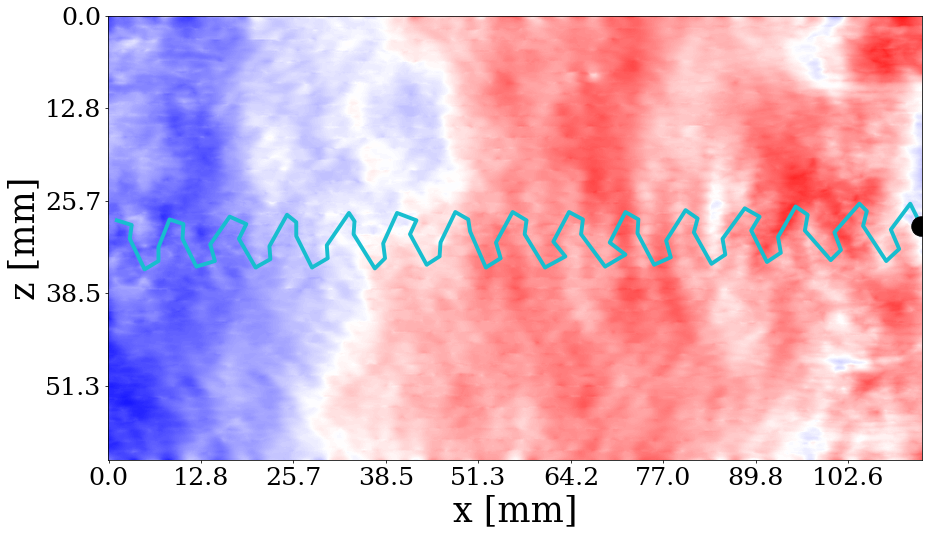

freq_l: 0.0  freq_r: 4.3
0 La longitud de onda promedio es:  5.292709962694884  \pm  0.3638021708101328 mm


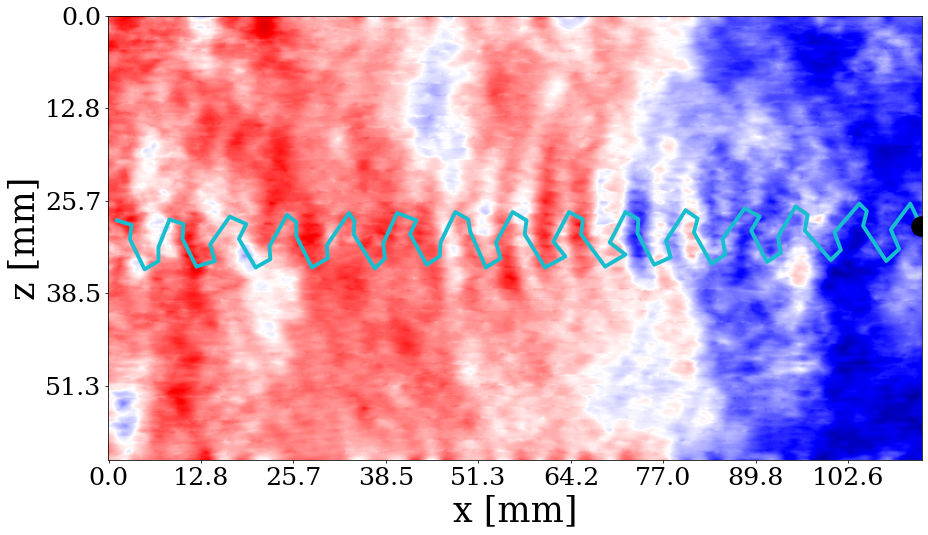

freq_l: 4.0  freq_r: 5.7
1 La longitud de onda promedio es:  4.747400451386926  \pm  0.3248075799960893 mm


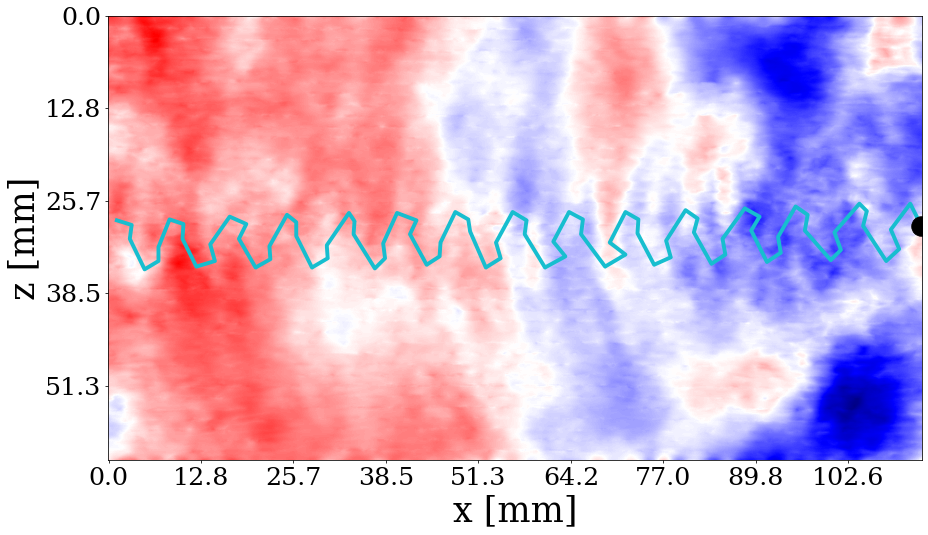

freq_l: 5.4  freq_r: 9.3
2 La longitud de onda promedio es:  4.3847905461693575  \pm  0.3154411125339968 mm


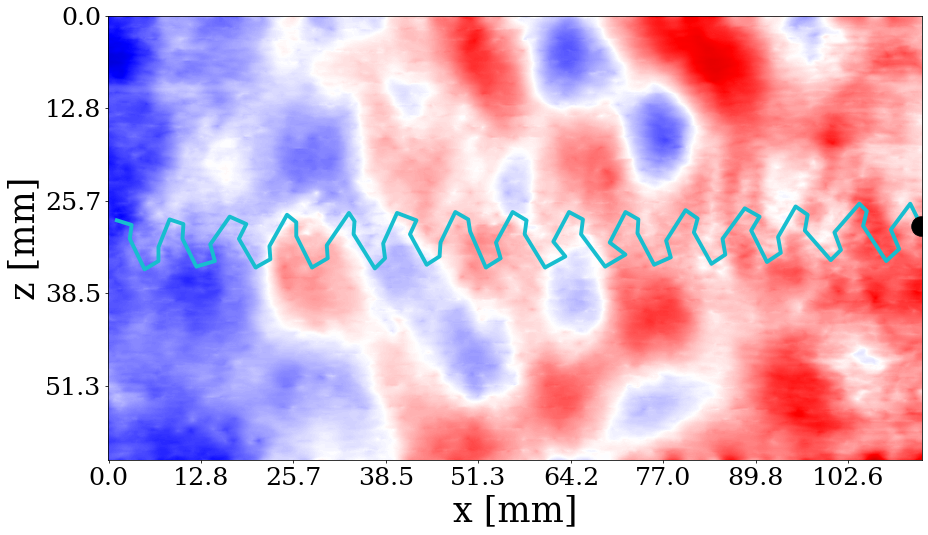

freq_l: 8.9  freq_r: 13.3
3 La longitud de onda promedio es:  5.355175758107869  \pm  0.6101598690518973 mm


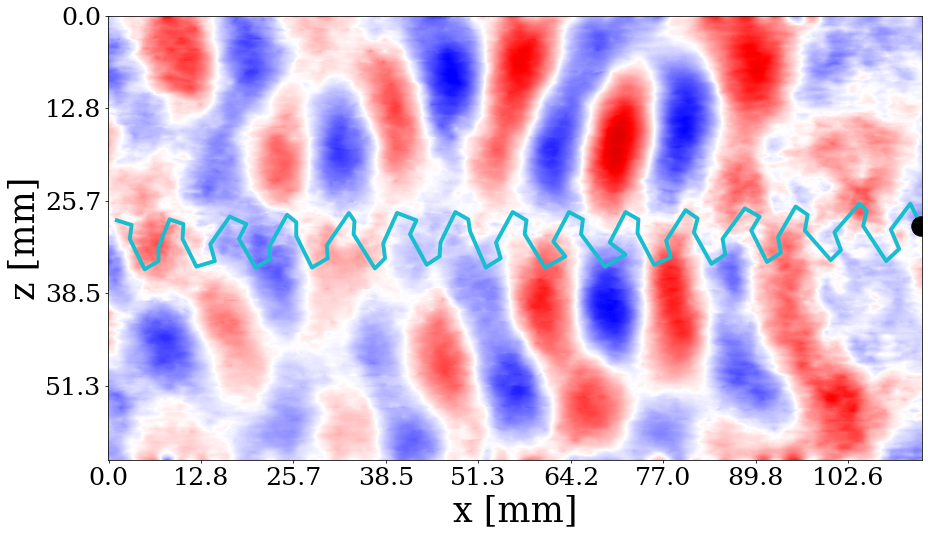

freq_l: 13.1  freq_r: 15.5
4 La longitud de onda promedio es:  5.42270634774353  \pm  0.522377995425589 mm


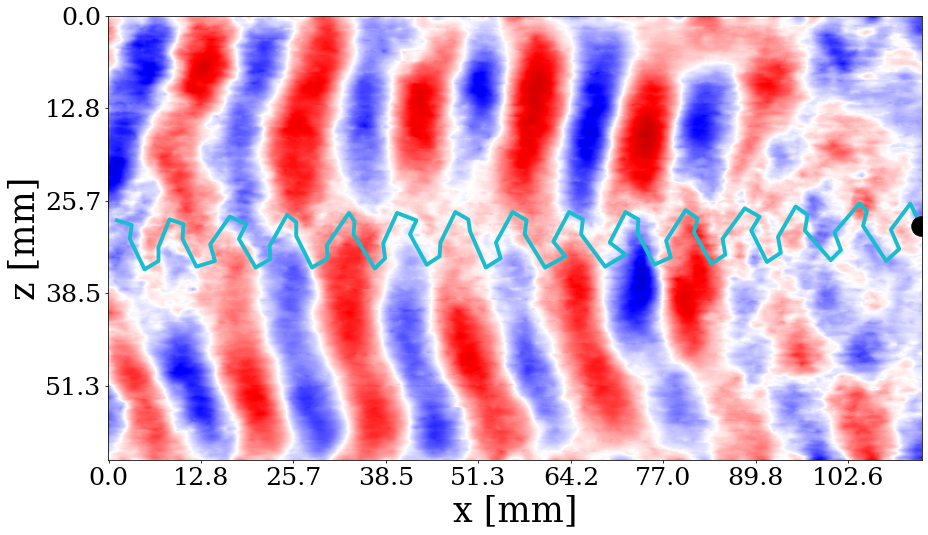

freq_l: 15.2  freq_r: 16.9
5 La longitud de onda promedio es:  6.173884847749611  \pm  0.7000015483028217 mm


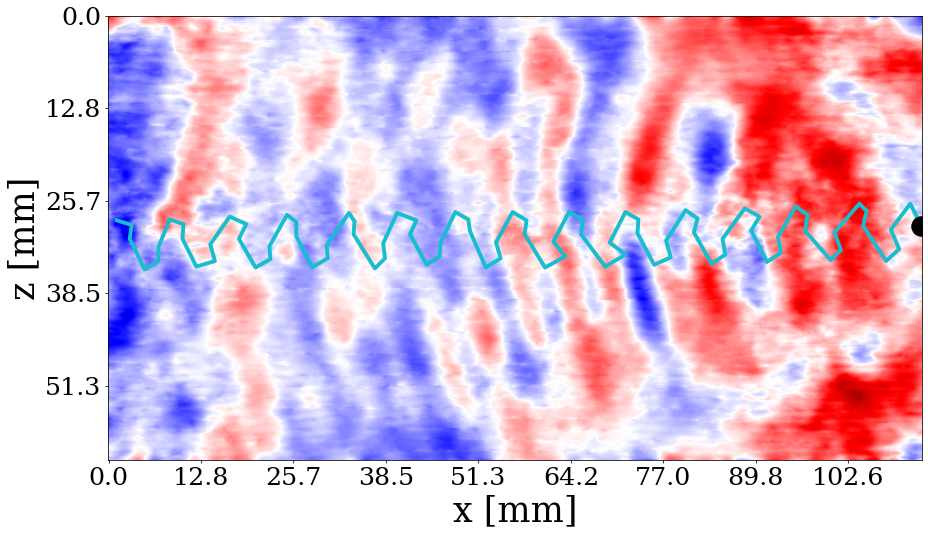

freq_l: 16.6  freq_r: 18.9
6 La longitud de onda promedio es:  5.4902369373791915  \pm  0.3910457262150194 mm


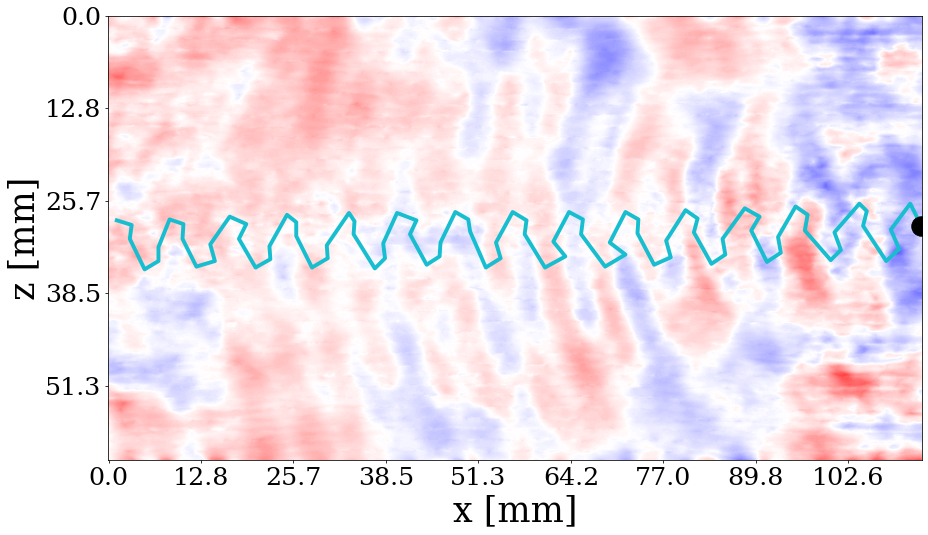

freq_l: 18.7  freq_r: 23.2
7 La longitud de onda promedio es:  5.273463744648721  \pm  0.4895841767485248 mm


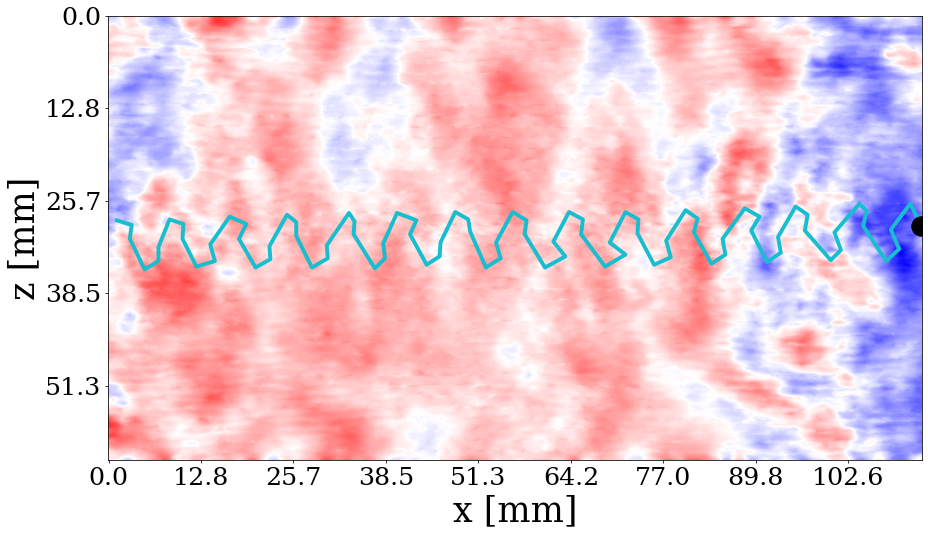

freq_l: 22.8  freq_r: 25.3
8 La longitud de onda promedio es:  3.958543119124434  \pm  0.2162833765376161 mm


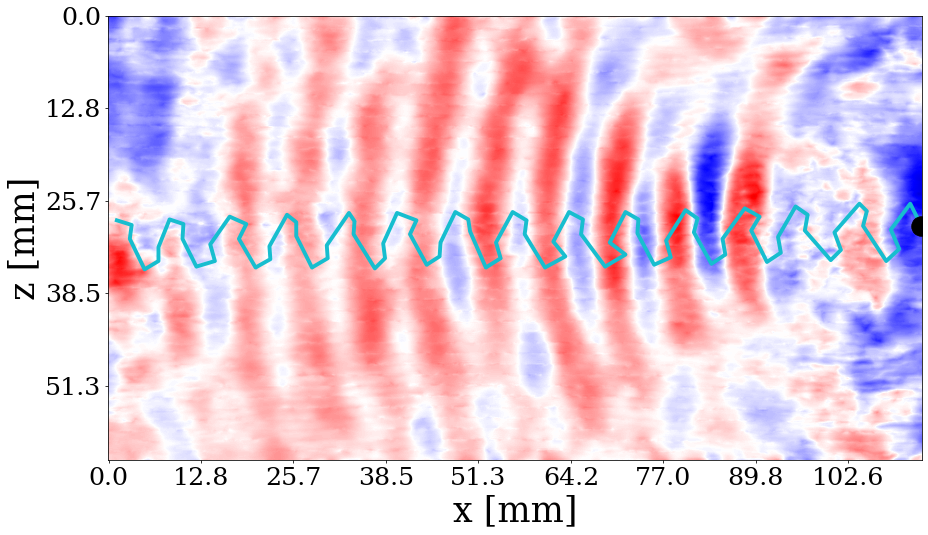

freq_l: 24.9  freq_r: 30.0
9 La longitud de onda promedio es:  8.019257519234673  \pm  0.6503019589904813 mm


In [80]:
xs = np.arange(0,x_len)
line_amp = (m*(xs - x_head) + y0).astype(int)

for i_filter in np.arange(len(f1)):
    s = len(maps) - 1
    filter_map = np.zeros((s,y_len,x_len))

    fr = np.linspace(0,30,s//2 + 1)
    filtro = np.ones_like(fr)
    filtro[np.where(np.logical_or(fr<f1.iloc[i_filter],fr>f2.iloc[i_filter]))] = 0

    for i in np.arange(y_len):
        for j in np.arange(x_len):
            masked_fft = np.fft.rfft(maps[:,i,j])*filtro
            filter_map[:,i,j] = np.fft.irfft((masked_fft))
    
    filter_frame = savgol_filter(filter_map[i_frame,line_amp,xs], polyorder=5, window_length=6)

    pk_l = find_peaks(filter_frame, width=[4,100], distance=15)[0]
    lambs = np.diff(xs[pk_l]/PX_PER_MM)
    l_mean = np.mean(lambs)
    l_std = np.std(np.diff(xs[pk_l]/PX_PER_MM))/np.sqrt(len(lambs))
    
    max_height = max([abs(filter_map[i]).max() for i in np.arange(len(filter_map))])
    norm = plt.Normalize(-max_height, max_height)
    cmap = plt.colormaps.get_cmap('seismic')
    colorscale = plt.cm.ScalarMappable(norm, cmap)
    
    fig2,ax2 = plt.subplots()
    im = ax2.imshow(filter_map[i_frame], aspect='equal', cmap=cmap, norm = norm)

    ax2.set_ylabel('z [mm]')
    ax2.set_xlabel('x [mm]')
    plt.plot(x,y, '.-', color='C9', ms=1, label='Trayectoria',lw=4)
    plt.plot(x_head,y_head,'o',ms=20,color='k', label='Cabeza') 
    plt.xticks(ticks= plt.xticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.xticks()[0][1:-1]])
    plt.yticks(ticks= plt.yticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.yticks()[0][1:-1]])
    plt.grid()
    plt.show()
    print("freq_l:",f1.iloc[i_filter]," freq_r:",f2.iloc[i_filter])
    print(i_filter,"La longitud de onda promedio es: ",l_mean," \pm ",l_std,"mm")

In [45]:
from matplotlib.patches import Circle

fig = plt.figure()
kx = np.fft.fftshift(np.fft.fftfreq(n = x_len, d = 1/PX_PER_MM))
ky = np.fft.fftshift(np.fft.fftfreq(n = y_len, d = 1/PX_PER_MM))

K=1000

for i_frame in tqdm(np.arange(len(filter_map))):
    F = np.abs(np.fft.fftshift(np.fft.fft2(filter_map[i_frame,:,:])))
    F = K*np.log(1 + F)
    plt.imshow(F, aspect='equal', extent=[kx[0],kx[-1], ky[0], ky[-1]])

circle = Circle((0,0), radius=2*np.pi/17, edgecolor='red', facecolor='none', lw=2)
fig.get_axes()[0].add_patch(circle)

plt.xlim(0,max(kx))
plt.ylim(0,max(ky))
plt.xlabel('$k_x$ [mm]')
plt.ylabel('$k_y$ [mm]')

plt.show()

NameError: name 'filter_map' is not defined

<Figure size 1050x700 with 0 Axes>

[344.75720792 -10.6143137 ] [75.80852185 24.37043   ]


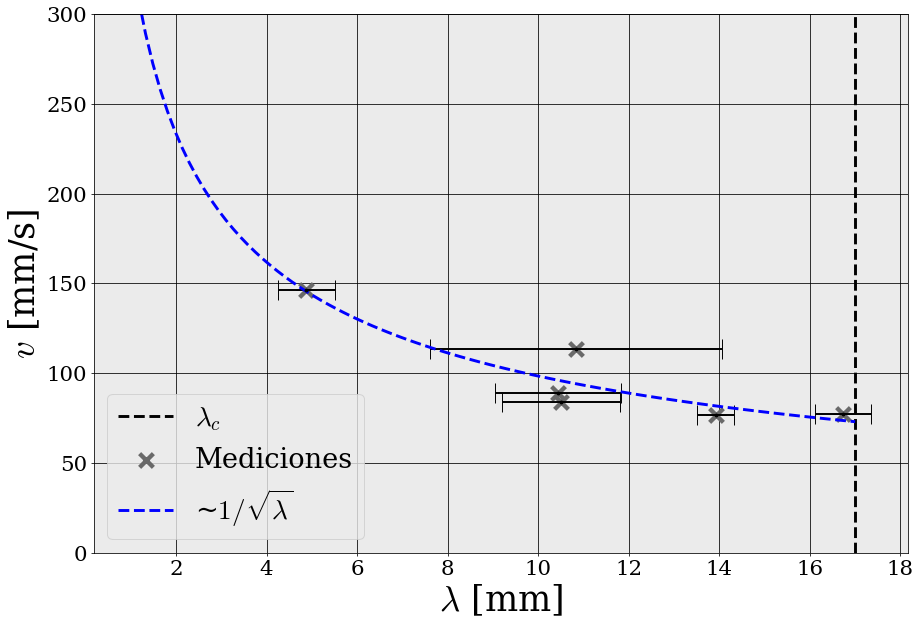

In [210]:
df = pd.read_csv('vg_vs_kc.csv')

vg = (np.abs(60*df['vel']/PX_PER_MM))
err_vg = (np.abs(60*df['err_vel']/PX_PER_MM))
lc = df['lambda [mm]']
err_lc = df['err_lambda [mm]']
frecs = df['frec']
volts = df['volt']
xvg = np.argsort(vg)
vg = vg[xvg]
lc = lc[xvg].dropna()

plt.figure()

colors = plt.cm.tab10(vg.index.values)

f_teoria = lambda x: (np.sqrt(50*1e3*2*np.pi))*x**(-1/2)
f_fit = lambda x,a,b: a*x**(-1/2) + b
ls = np.linspace(1,17,100)

popt, popv  = curve_fit(f_fit, xdata=lc,ydata=vg)

plt.axvline(17, label='$\lambda_c$', ls='--', color='k', lw=3)
plt.scatter(lc,vg, color = 'dimgray',marker='x', s=10, linewidths=20, label='Mediciones')
plt.errorbar(lc, vg, fmt='.', yerr = err_vg, xerr = err_lc, color = 'k', ecolor = 'k',elinewidth=2, lw=3, capsize=10)

    
plt.plot(ls, f_fit(ls,*popt), color='b', ls='--', lw=3, label='~$1/\sqrt{\lambda}$')

plt.ylabel('$v$ [mm/s]')
plt.xlabel('$\lambda$ [mm]')
plt.ylim(0,300)
plt.legend()

print(popt, np.sqrt(np.diag(popv)))

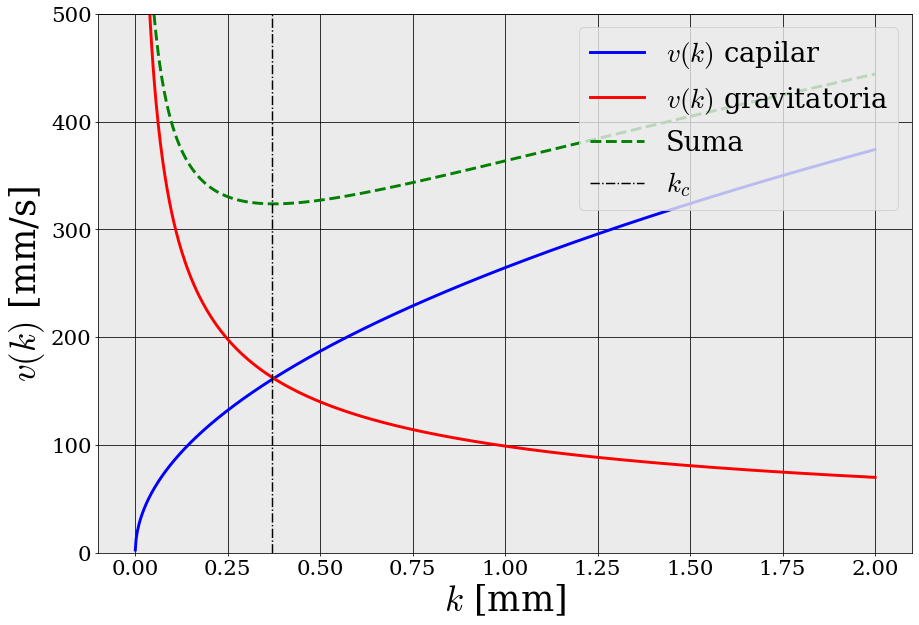

In [203]:
ks = np.linspace(1e-4,2,1_000)

f_capilar = lambda x: np.sqrt(70*1e3)*x**(1/2)
f_gravitatoria = lambda x: np.sqrt(9.81*1e3)*x**(-1/2)

plt.plot(ks,f_capilar(ks), color='b',lw=3,label='$v(k)$ capilar')
plt.plot(ks,f_gravitatoria(ks),color='r',lw=3,label='$v(k)$ gravitatoria')
plt.plot(ks, f_capilar(ks) + f_gravitatoria(ks), color='g', ls='--', lw=3, label='Suma')
plt.axvline(2*np.pi/17, color='k', ls='-.', label='$k_c$')

plt.ylim(0,500)
plt.ylabel('$v(k)$ [mm/s]')
plt.xlabel('$k$ [mm]')
plt.legend(loc='upper right')

## Relación de dispersión

In [81]:
data = pd.read_csv('exploratory_wk.csv').dropna()
calibrations = pd.read_csv('calibrations_fcd_dsk_60mm.csv')
velocidades = pd.read_csv('DSK-60mm/velocidades.csv')

In [82]:
l = []
dl = []
w = []
dw = []
vel = []
dvel = []
for f,v in zip(calibrations['freq [Hz]'],calibrations['volt [Vpp]']):
    calibration_mask = np.logical_and(calibrations['freq [Hz]']==f, calibrations['volt [Vpp]']==v)
    data_mask = np.logical_and(data['freq [Hz]']==f, data['volt [Vpp]']==v)
    vel_mask = np.logical_and(velocidades['freq [Hz]']==f, velocidades['volt [Vpp]']==v)
    
    if data_mask.any():
        px_per_mm = calibrations[calibration_mask]['calibration [px mm-1]'].iloc[0]
        curr_data = data[data_mask].iloc[0]
        curr_vel = velocidades[vel_mask].iloc[0]
        l.append(curr_data['lambda [px]']/px_per_mm)
        dl.append(curr_data['delta_lambda [px]']/px_per_mm)
        w.append(curr_data['peak_frec [Hz]'])
        dw.append(
            np.abs(curr_data['peak_frec [Hz]'] - curr_data['f1 [Hz]']) +
            np.abs(curr_data['peak_frec [Hz]'] - curr_data['f2 [Hz]'])
        )
        vel.append(np.abs(curr_vel['vel'])*(FRAME_PER_SECOND/px_per_mm))
        dvel.append(curr_vel['vel_err']*(FRAME_PER_SECOND/px_per_mm))

In [83]:
lix = np.argsort(l)
l = np.array(l)[lix]
w = 2*np.pi*np.array(w)[lix]
vel = np.array(vel)[lix]
dl = np.array(dl)[lix]
dw = 2*np.pi*np.array(dw)[lix]
dvel = np.array(dvel)[lix]

In [84]:
f = lambda l,b: np.sqrt(9810*(2*np.pi/l) + b*(2*np.pi/l)**3*np.tanh((2*np.pi/l)*53))

popt,popv = curve_fit(f=f, ydata=w, xdata=l, sigma=dw)

err_popt = np.sqrt(np.diag(popv))

ls = np.linspace(8,18)
ws = f(ls,*popt)
ws_down = f(ls, popt[0] - err_popt[0])
ws_up = f(ls, popt[0] + err_popt[0])

gamma = popt[0]

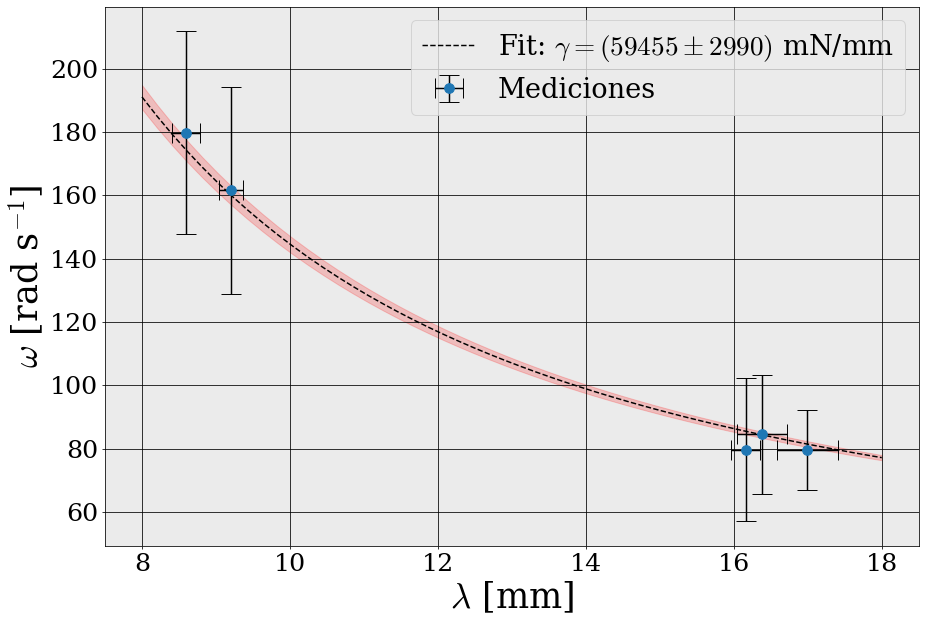

In [85]:
%matplotlib inline
plt.errorbar(x = l, y = w, yerr=dw, xerr=dl, fmt='o', ecolor='k', ms=10, capsize=10, label='Mediciones')
plt.plot(ls,ws, label=f"Fit: $\gamma = ({popt[0]:.0f} \pm {err_popt[0]:.0f})$ mN/mm",color='k',ls='--')
plt.fill_between(ls, y1 = ws_down, y2 = ws_up, zorder=0, color='r', alpha=0.2)
plt.xlabel('$\lambda$ [mm]')
plt.ylabel('$\omega$ [rad s$^{-1}$]')
plt.legend()
plt.show()

In [55]:
f = lambda l,a,b: a*np.sqrt( (9810*(2*np.pi/l)**(-1) + b*(2*np.pi/l))*np.tanh((2*np.pi/l)*53) )

popt,popv = curve_fit(f=f, ydata=vel, xdata=l, sigma=dvel, p0=[1,gamma])

err_popt = np.sqrt(np.diag(popv))

ls = np.linspace(8,18)
vs = f(ls,*popt)
vs_down = f(ls, *(popt - err_popt))
vs_up = f(ls, *(popt + err_popt))

/tmp/ipykernel_6751/3641164148.py:1: RuntimeWarning: invalid value encountered in sqrt
  f = lambda l,a,b: a*np.sqrt( (9810*(2*np.pi/l)**(-1) + b*(2*np.pi/l))*np.tanh((2*np.pi/l)*53) )


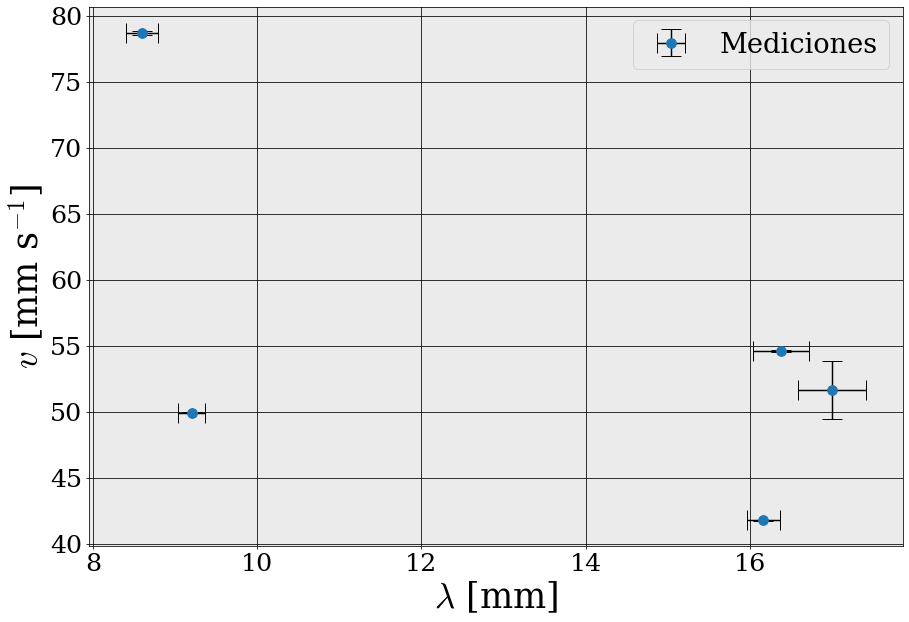

In [57]:
plt.errorbar(x = l, y = vel, yerr=dvel, xerr=dl, fmt='o', ecolor='k', ms=10, capsize=10, label='Mediciones')
# plt.plot(ls,vs, label=f"$v(\lambda)$ con $\gamma = {gamma:.0f}$ mN/mm",color='k',ls='--')
plt.xlabel('$\lambda$ [mm]')
plt.ylabel('$v$ [mm s$^{-1}$]')
plt.legend()

In [677]:
l = []
dl = []
fs = []
vs = []
for f,v in zip(calibrations['freq [Hz]'],calibrations['volt [Vpp]']):
    calibration_mask = np.logical_and(calibrations['freq [Hz]']==f, calibrations['volt [Vpp]']==v)
    data_mask = np.logical_and(data['freq [Hz]']==f, data['volt [Vpp]']==v)
    if data_mask.any():
        px_per_mm = calibrations[calibration_mask]['calibration [px mm-1]'].iloc[0]
        curr_data = data[data_mask]
        l.append(curr_data['lambda [px]'].iloc[0]/px_per_mm)
        dl.append(curr_data['delta_lambda [px]'].iloc[0]/px_per_mm)
        fs.append(f)
        vs.append(v)

lix = np.argsort(l)
l = np.array(l)[lix]
dl = np.array(dl)[lix]
fs = np.array(fs)[lix]
vs = np.array(vs)[lix]

In [639]:
norm = plt.Normalize(min(vs),max(vs))
cmap = plt.colormaps.get_cmap('viridis')
cscale = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

[]

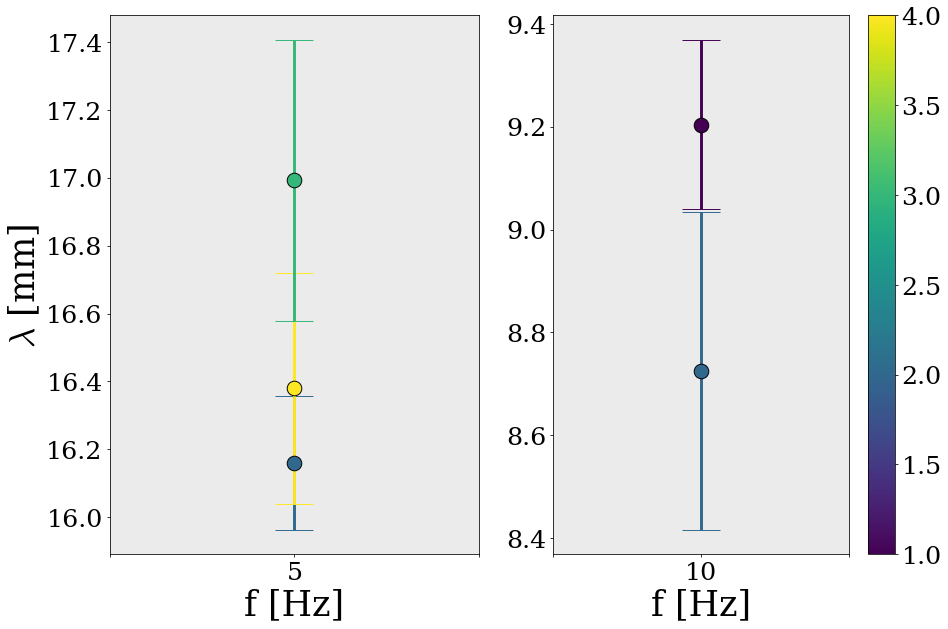

In [697]:
fig,(ax1,ax2) = plt.subplots(1,2)

f5m = fs==5
f10m = fs==10

for f,l_,dl_,v,c in zip(fs[f5m],l[f5m],dl[f5m],vs[f5m],cmap(norm(vs))[f5m]):
    ax1.errorbar(x = f, y = l_, yerr=dl_, xerr=None, 
            fmt='o', ecolor=cmap(norm(v)), ms=15, capsize=20, lw=3, color=cmap(norm(v)),markeredgecolor='k')

for f,l_,dl_,v,c in zip(fs[f10m],l[f10m],dl[f10m],vs[f10m],cmap(norm(vs))[f10m]):
    ax2.errorbar(x = f, y = l_, yerr=dl_, xerr=None, 
            fmt='o', ecolor=cmap(norm(v)), ms=15, capsize=20, lw=3, color=cmap(norm(v)),markeredgecolor='k')

fig.colorbar(cscale, ax=ax2)
ax1.grid();ax2.grid()

ax1.set_xlabel('f [Hz]')
ax1.set_ylabel('$\lambda$ [mm]')
ax2.set_xlabel('f [Hz]')

ax1.set_xticks([4,5,6])
ax1.set_xticklabels(['','5',''])
ax2.set_xticks([9,10,11])
ax2.set_xticklabels(['','10',''])
[]